# YCSB Analysis of Grid of Parameters
Loop over
* several target throughputs
* several numers of threads
* split into 1, 8 and 16 driver pods


```
nohup python ycsb.py -ms 1 -tr \
  -sf $BEXHOMA_YCSB_SF_DATA \
  -sfo $BEXHOMA_YCSB_SF_OPS \
  --workload c \
  -dbms PostgreSQL \
  -rnn $BEXHOMA_NODE_SUT -rnl $BEXHOMA_NODE_LOAD -rnb $BEXHOMA_NODE_BENCHMARK \
  -tb 16384 \
  -nlp 8 \
  -nlt 64 \
  -nlf 12 \
  -nbp 1,1,8,16 \
  -nbt 80,96,112,128,144,160,176,192 \
  -nbf 0,9,10,11,12,13,14,15,16 \
  -ne 1 \
  -nc 2 \
  -m -mc \
  -rst shared -rss 50Gi run
```

In [1]:
code = "1739274625"
path = "D:\\data\\benchmarks"
#path = "/home/perdelt/benchmarks"

In [2]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [3]:
cut_at = 0

#pod_count = 16
#experiment_run = 1
#target = 0
#threads = 128


def plot_timeseries(df_aggregated, metric, pod_count, experiment_run, target, threads, smoothing=0):
    df = df_aggregated.copy()
    if experiment_run > 0:
        df = df[df['experiment_run'] == experiment_run]
    df = df[df['target'] == target]
    df = df[df['threads'] == threads]
    df_subset = df[df['pod_count'] == pod_count]
    df_subset = df_subset[~df_subset.duplicated(subset=['threads', 'target'], keep='last')]
    client = df_subset['client'].iloc[0]
    plot_measures(metric, smoothing=smoothing, preset_experiment_run=experiment_run, preset_client=client)

def plot_measures(metric, smoothing=0, preset_experiment_run=0, preset_client=0):
    display(Markdown(f'# Metric {metric}'))
    list_configurations = list(df_benchmarks['configuration'].unique())    
    for configuration in list_configurations:
        display(Markdown(f'## Configuration {configuration}'))
        list_experiment_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration]['experiment_run'].unique()))
        for experiment_run in list_experiment_runs:
            if preset_experiment_run > 0:
                if preset_experiment_run != experiment_run:
                    continue
            display(Markdown(f'### Experiment run {experiment_run}'))
            list_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['client'].unique()))
            #list_targets = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['target'].unique()))
            num_runs = len(list_runs)
            # Create a 2-column grid layout
            n_cols = 2
            if preset_client > 0:
                n_rows = 1
            else:
                n_rows = num_runs
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows), sharex=True)
            fig.suptitle(f"{metric}", fontsize=16)#, fontweight="bold")
            # Flatten axes for easy iteration (handles cases with n_rows == 1 or n_cols == 1)
            axes = axes.flatten()
            i = 0
            for client in list_runs:
                if preset_client > 0:
                    if preset_client != client:
                        continue
                #################################
                # show plots with aggregated line
                #################################
                # filter data for this run
                df_part = df_benchmarks[df_benchmarks['configuration'] == configuration]
                df_part = df_part[df_part['experiment_run'] == (experiment_run)]
                df_part = df_part[df_part['client'] == (client)]
                df_total = evaluation.get_benchmark_logs_timeseries_df_aggregated(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
                threads = df_part['threads'].sum()
                pod_count = df_part['pod_count'].mean()
                target = df_part['target'].sum()
                # Compute the time spans
                time_spans = df_total.index.to_series().diff().shift(-1).fillna(0)  # Difference between consecutive time indices
                # Weighted average: Multiply each value by its duration and sum
                weighted_sum = (df_total[metric].multiply(time_spans, axis=0)).sum().sum()  # Multiply each value by its time span, sum all values
                total_time = time_spans.sum()  # Total time span
                # Compute the weighted average
                weighted_average = weighted_sum / total_time
                df_total['avg'] = weighted_average
                df_total = df_total.rename(columns={'avg': f'avg={weighted_average}'})
                #df_total = df_total.fillna(0)
                # optionally smoothen graph
                if smoothing > 0:
                    df_total[metric] = df_total[metric].rolling(window=smoothing, min_periods=1).mean()
                # optionally leave out data at the end (cool down)
                if cut_at > 0:
                    df_total = df_total[:-cut_at]
                # generate plot
                title = "{}/{} threads - target = {}".format(threads, int(pod_count), target)
                ax = axes[i]
                i = i + 1
                max_value = df_total[metric].max()
                #print(max_value)
                df_total.plot(title=title, ax=ax, ylim=(0,max_value*1.1), use_index=True)
                last_x = df_total.index[-1] # Get the last datapoint's x-coordinate (the last index)
                ax.axvline(x=last_x, color='red', linestyle='--', label='Last Datapoint') # Add a vertical line at the last datapoint
                ###############################
                # show plots with lines per pod
                ###############################
                df_list = evaluation.get_benchmark_logs_timeseries_df_single(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
                # collect in one dataframe
                df_total = pd.DataFrame()
                j=1
                max_value = 0
                for df in df_list:
                    # optionally leave out data at the end (cool down)
                    if cut_at > 0:
                        df_tmp = df[metric][:-cut_at]
                    else:
                        df_tmp = df[metric]
                    df_single = pd.DataFrame(df_tmp)
                    if max_value < df_single[metric].max():
                        max_value = df_single[metric].max()
                    df_single.columns=["pod "+str(j)]
                    df_total = pd.merge(df_total, df_single, how='outer', left_index=True, right_index=True)
                    j = j + 1
                #print(df_combined)
                # Compute the time spans
                time_spans = df_total.index.to_series().diff().shift(-1).fillna(0)  # Difference between consecutive time indices
                weighted_sum = (df_total.multiply(time_spans, axis=0)).sum().sum()  # Multiply each value by its time span, sum all values
                total_time = time_spans.sum()  # Total time span
                # Compute the weighted average
                weighted_average = weighted_sum / total_time / len(df_list)
                df_total['avg'] = weighted_average
                df_total = df_total.rename(columns={'avg': f'avg={weighted_average}'})
                #df_total = df_total.fillna(0)
                # optionally smoothen graph
                if smoothing > 0:
                    df_total = df_total.rolling(window=smoothing, min_periods=1).mean()
                # generate plot
                title = "{}/{} threads - target = {}".format(threads, int(pod_count), target)
                ax = axes[i]
                i = i + 1
                df_total.plot(title=title, ax=ax, ylim=(0,max_value*1.1), use_index=True, legend=False)
                last_x = df_total.index[-1] # Get the last datapoint's x-coordinate (the last index)
                ax.axvline(x=last_x, color='red', linestyle='--', label='Last Datapoint') # Add a vertical line at the last datapoint
            # Hide any unused subplots
            for j in range(num_runs*2, len(axes)):
                fig.delaxes(axes[j])
            plt.tight_layout()
            filename = f"plot_{preset_experiment_run}_{preset_client}_{metric}.png".replace("\\","").replace("/","").replace(":","")
            #df2img.save_dataframe(styled_df, filename="styled_table.png")
            plt.savefig(filename, dpi=300, bbox_inches="tight")
            plt.show()

def plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=None, vmax_value=None):
    #metric = '[OVERALL].Throughput(ops/sec)'
    #pod_count = 1
    #experiment_run = 1
    df = df_aggregated[['experiment_run', 'threads', 'target', 'pod_count', metric]]
    df = df[df['pod_count'] == pod_count]
    df = df[df['experiment_run'] == experiment_run]
    df = df[~df.index.duplicated(keep='last')]
    df = df[~df.duplicated(subset=['threads', 'target'], keep='last')]
    #print(df)
    df = df.pivot(index='threads', columns='target', values=metric)
    #display(df.style.background_gradient(cmap='Blues', axis=None))
    styled_df = df.style.background_gradient(cmap='Blues', axis=None).set_caption(metric)
    #df.style.background_gradient(cmap='Blues', axis=None).set_caption(metric)
    #df.style.background_gradient()
    #display(df)
    # Set up the figure size
    plt.figure(figsize=(10, 4))
    # Create the heatmap
    if vmin_value is not None and vmax_value is not None:
        ax = sns.heatmap(df, annot=True, cmap="Blues", fmt=".0f", linewidths=0.5, annot_kws={"size": 7}, vmin=vmin_value, vmax=vmax_value)
    else:
        ax = sns.heatmap(df, annot=True, cmap="Blues", fmt=".0f", linewidths=0.5, annot_kws={"size": 7})
    ax.set_title(metric)
    # Save as PNG
    filename = (f"heatmap_{metric}_{pod_count}_{experiment_run}.png").replace("\\","").replace("/","").replace(":","")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # Show the plot (optional)
    plt.show()


def plot_heatmap_compare(df_aggregated, metric, pod_count_1, pod_count_2, experiment_run, vmin_value=None, vmax_value=None):
    df = df_aggregated[['experiment_run', 'threads', 'target', 'pod_count', metric]]
    df = df[df['pod_count'] == pod_count_1]
    df = df[df['experiment_run'] == experiment_run]
    df = df[~df.index.duplicated(keep='last')]
    df = df[~df.duplicated(subset=['threads', 'target'], keep='last')]
    #print(df)
    df_1 = df.pivot(index='threads', columns='target', values=metric)
    pod_count = 8
    df = df_aggregated[['experiment_run', 'threads', 'target', 'pod_count', metric]]
    df = df[df['pod_count'] == pod_count_2]
    df = df[df['experiment_run'] == experiment_run]
    df = df[~df.index.duplicated(keep='last')]
    df = df[~df.duplicated(subset=['threads', 'target'], keep='last')]
    #print(df)
    df_2 = df.pivot(index='threads', columns='target', values=metric)
    df = df_2/df_1*100
    #print(df)
    #vmin_value = 0
    #vmax_value = 200
    #display(df.style.background_gradient(cmap='Blues', axis=None))
    styled_df = df.style.background_gradient(cmap='YlOrBr', axis=None).set_caption(metric)
    #df.style.background_gradient(cmap='Blues', axis=None).set_caption(metric)
    #df.style.background_gradient()
    #display(df)
    # Set up the figure size
    plt.figure(figsize=(10, 4))
    # Create the heatmap
    if vmin_value is not None and vmax_value is not None:
        ax = sns.heatmap(df, annot=True, cmap="YlOrBr", fmt=".0f", linewidths=0.5, annot_kws={"size": 7}, vmin=vmin_value, vmax=vmax_value)
    else:
        ax = sns.heatmap(df, annot=True, cmap="YlOrBr", fmt=".0f", linewidths=0.5, annot_kws={"size": 7})
    ax.set_title(f"Increasement of {metric} in %")
    # Save as PNG
    filename = (f"heatmap_increase_{metric}_{pod_count_1}_{pod_count_2}_{experiment_run}.png").replace("\\","").replace("/","").replace(":","")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # Show the plot (optional)
    plt.show()


def plot_prometheus_metric(df_aggregated, metric, component, pod_count, experiment_run):
    df_aggregated = pd.DataFrame(df_aggregated, columns=[metric])
    #print(df_aggregated)
    df_benchmarks2 = df_benchmarks.set_index('connection')
    df_benchmarks2['threads_total'] = df_benchmarks2['threads']*df_benchmarks2['pod_count']
    df = df_aggregated.join(df_benchmarks2, how='inner')
    df = df[df['pod_count'] == pod_count]
    df = df[df['experiment_run'] == experiment_run]
    df = df[~df.index.duplicated(keep='last')]
    df = df[~df.duplicated(subset=['threads', 'target'], keep='last')]
    #print(df_heatmap)
    df = df.pivot(index='threads_total', columns='target', values=metric)
    #display(df_heatmap.style.background_gradient(cmap='Blues', axis=None))
    df.plot.bar(title=f"{component} ({experiment_run}. run with {pod_count} pods): {metric}")
    filename = f"bar_{component}_{experiment_run}_{pod_count}_{metric}.png".replace("\\","").replace("/","").replace(":","")
    plt.savefig(filename, dpi=300, bbox_inches="tight")


In [4]:
evaluation = evaluators.ycsb(code=code, path=path)

## Table of Data

In [5]:
df_benchmarks = evaluation.get_df_benchmarking()
#df = df[df.columns.drop(list(df.filter(regex='FAILED')))]
df_benchmarks = evaluation.benchmarking_set_datatypes(df_benchmarks)
df_benchmarks.T

connection_pod,PostgreSQL-64-8-196608-1-151-1,PostgreSQL-64-8-196608-1-164-1,PostgreSQL-64-8-196608-2-11-1,PostgreSQL-64-8-196608-2-204-1,PostgreSQL-64-8-196608-1-7-1,PostgreSQL-64-8-196608-1-40-1,PostgreSQL-64-8-196608-1-252-1,PostgreSQL-64-8-196608-1-256-1,PostgreSQL-64-8-196608-1-115-1,PostgreSQL-64-8-196608-1-232-1,...,PostgreSQL-64-8-196608-1-143-8,PostgreSQL-64-8-196608-2-87-8,PostgreSQL-64-8-196608-1-48-16,PostgreSQL-64-8-196608-2-199-8,PostgreSQL-64-8-196608-1-138-1,PostgreSQL-64-8-196608-2-16-16,PostgreSQL-64-8-196608-1-172-16,PostgreSQL-64-8-196608-1-280-16,PostgreSQL-64-8-196608-2-219-8,PostgreSQL-64-8-196608-1-72-16
connection,PostgreSQL-64-8-196608-1-151,PostgreSQL-64-8-196608-1-164,PostgreSQL-64-8-196608-2-11,PostgreSQL-64-8-196608-2-204,PostgreSQL-64-8-196608-1-7,PostgreSQL-64-8-196608-1-40,PostgreSQL-64-8-196608-1-252,PostgreSQL-64-8-196608-1-256,PostgreSQL-64-8-196608-1-115,PostgreSQL-64-8-196608-1-232,...,PostgreSQL-64-8-196608-1-143,PostgreSQL-64-8-196608-2-87,PostgreSQL-64-8-196608-1-48,PostgreSQL-64-8-196608-2-199,PostgreSQL-64-8-196608-1-138,PostgreSQL-64-8-196608-2-16,PostgreSQL-64-8-196608-1-172,PostgreSQL-64-8-196608-1-280,PostgreSQL-64-8-196608-2-219,PostgreSQL-64-8-196608-1-72
configuration,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,...,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608
experiment_run,1,1,2,2,1,1,1,1,1,1,...,1,2,1,2,1,2,1,1,2,1
client,151,164,11,204,7,40,252,256,115,232,...,143,87,48,199,138,16,172,280,219,72
pod,1526zjf.dbmsbenchmarker,16hh4b2.dbmsbenchmarker,11pxbt8.dbmsbenchmarker,20prjnw.dbmsbenchmarker,znt86.dbmsbenchmarker,40ssm7c.dbmsbenchmarker,25b9xz6.dbmsbenchmarker,25q6j97.dbmsbenchmarker,11x45tz.dbmsbenchmarker,23zqj8h.dbmsbenchmarker,...,14hfgng.dbmsbenchmarker,87hng42.dbmsbenchmarker,48295l4.dbmsbenchmarker,19mc24v.dbmsbenchmarker,13kl5l4.dbmsbenchmarker,16km225.dbmsbenchmarker,17wr59m.dbmsbenchmarker,28qhbgw.dbmsbenchmarker,21lxkzd.dbmsbenchmarker,72nhhv5.dbmsbenchmarker
pod_count,8,16,8,16,8,16,16,16,8,16,...,8,8,16,8,1,16,16,16,8,16
threads,20,5,14,7,12,6,11,12,18,6,...,16,20,8,12,112,8,7,10,22,6
target,24576,13312,0,14336,0,9216,15360,15360,22528,15360,...,24576,20480,9216,28672,196608,0,13312,16384,28672,10240
sf,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
workload,c,c,c,c,c,c,c,c,c,c,...,c,c,c,c,c,c,c,c,c,c


## Heatmaps of Macro Values

In [6]:
df_aggregated = evaluation.benchmarking_aggregate_by_parallel_pods(df_benchmarks)
experiment_run = 2

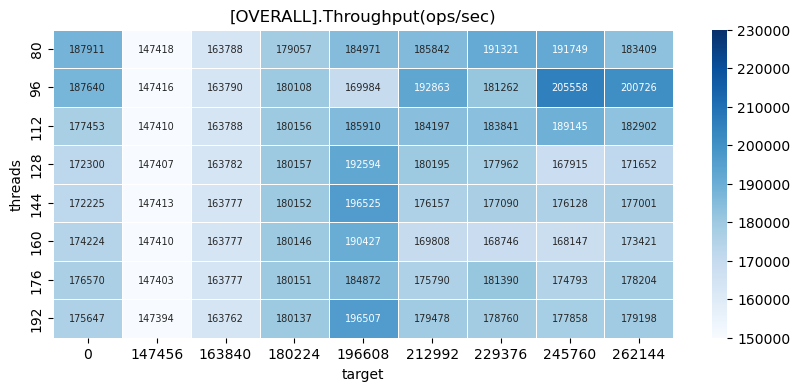

In [7]:
metric = '[OVERALL].Throughput(ops/sec)'
pod_count = 1
experiment_run = 2
vmin_value = 150000
vmax_value = 230000
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

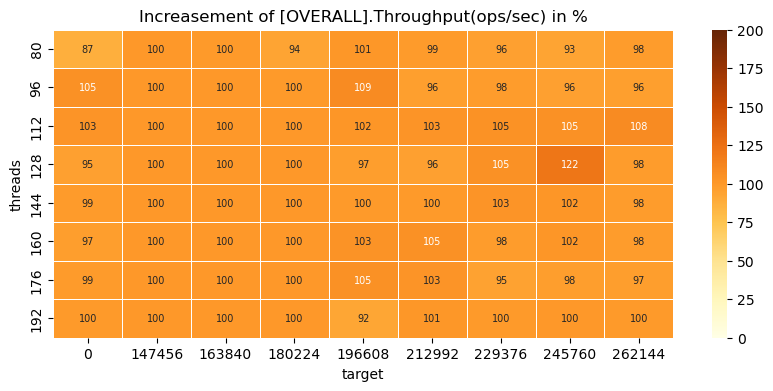

In [8]:
metric = '[OVERALL].Throughput(ops/sec)'
#metric = '[READ].AverageLatency(us)'
#metric = '[READ].MaxLatency(us)'
#metric = '[READ].MinLatency(us)'
#metric = '[READ].99thPercentileLatency(us)'
pod_count_1 = 1
pod_count_2 = 8
experiment_run = 2
vmin_value = 0
vmax_value = 200
plot_heatmap_compare(df_aggregated, metric, pod_count_1, pod_count_2, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

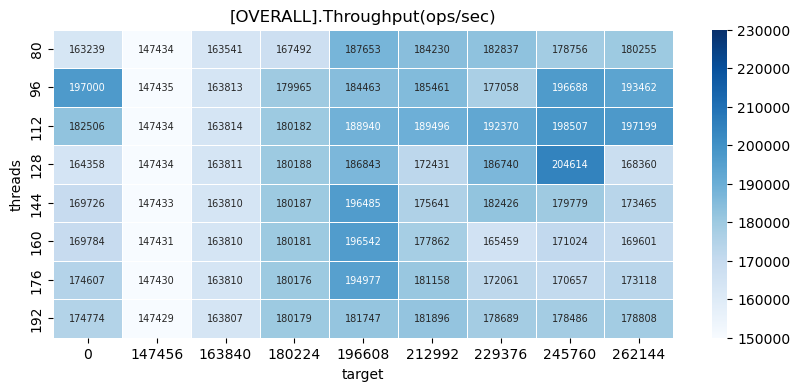

In [9]:
metric = '[OVERALL].Throughput(ops/sec)'
pod_count = 8
experiment_run = 2
vmin_value = 150000
vmax_value = 230000
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

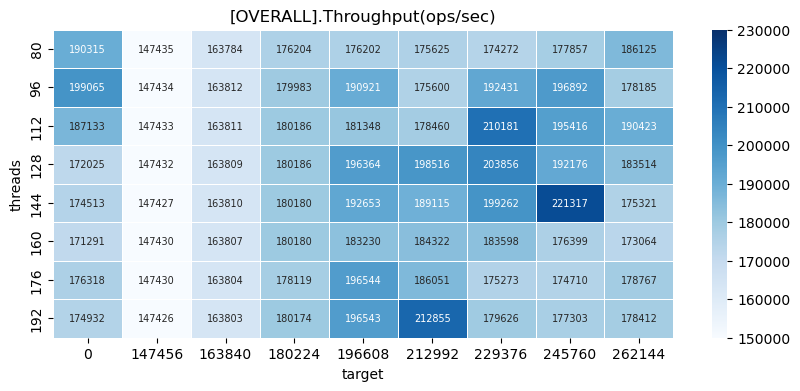

In [10]:
metric = '[OVERALL].Throughput(ops/sec)'
pod_count = 16
experiment_run = 2
vmin_value = 150000
vmax_value = 230000
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

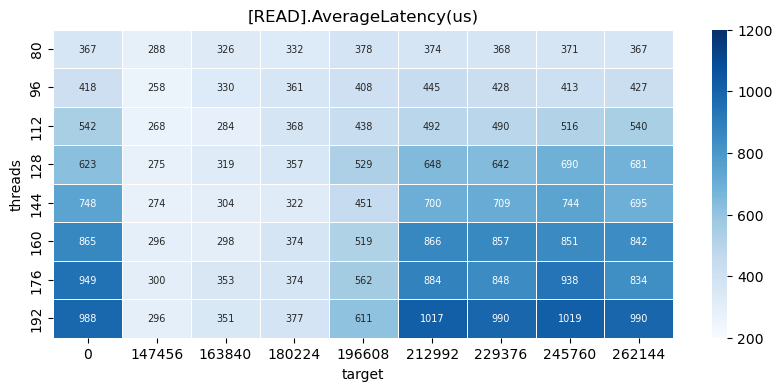

In [11]:
metric = '[READ].AverageLatency(us)'
pod_count = 1
experiment_run = 2
vmin_value = 200
vmax_value = 1200
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

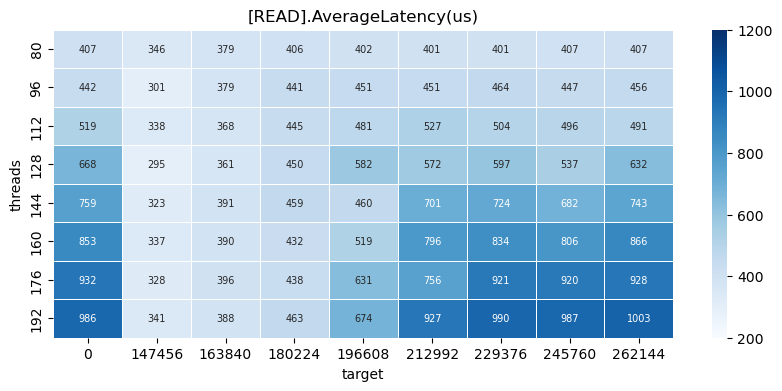

In [12]:
metric = '[READ].AverageLatency(us)'
pod_count = 8
experiment_run = 2
vmin_value = 200
vmax_value = 1200
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

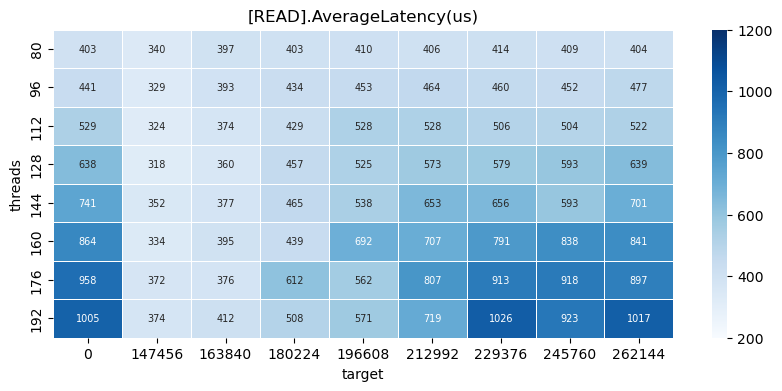

In [13]:
metric = '[READ].AverageLatency(us)'
pod_count = 16
experiment_run = 2
vmin_value = 200
vmax_value = 1200
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

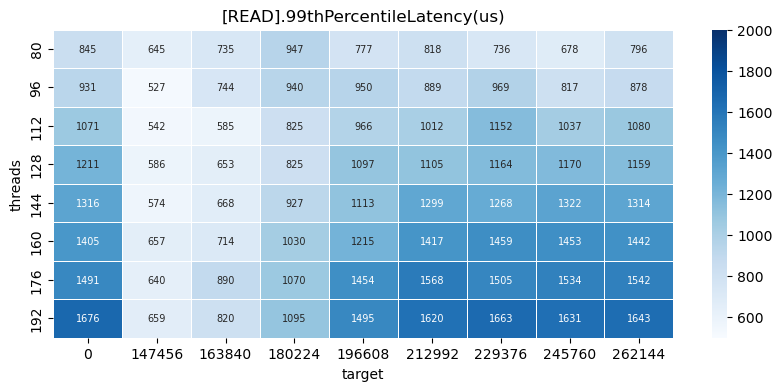

In [14]:
metric = '[READ].99thPercentileLatency(us)'
pod_count = 1
experiment_run = 2
vmin_value = 500
vmax_value = 2000
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

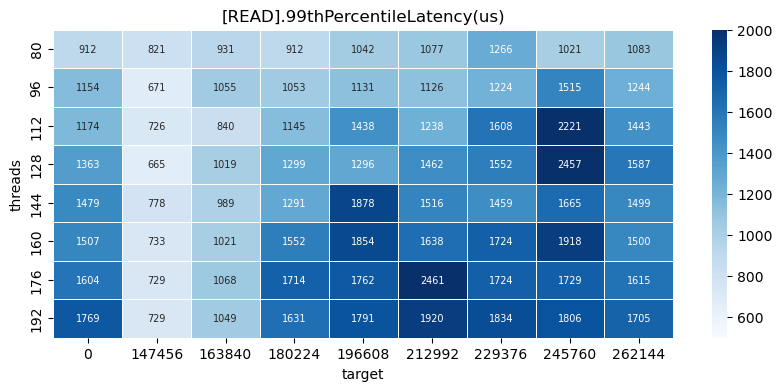

In [15]:
metric = '[READ].99thPercentileLatency(us)'
pod_count = 8
experiment_run = 2
vmin_value = 500
vmax_value = 2000
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

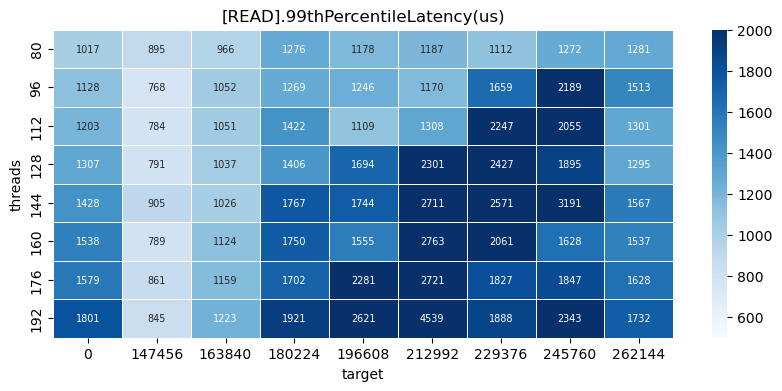

In [16]:
metric = '[READ].99thPercentileLatency(us)'
pod_count = 16
experiment_run = 2
vmin_value = 500
vmax_value = 2000
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

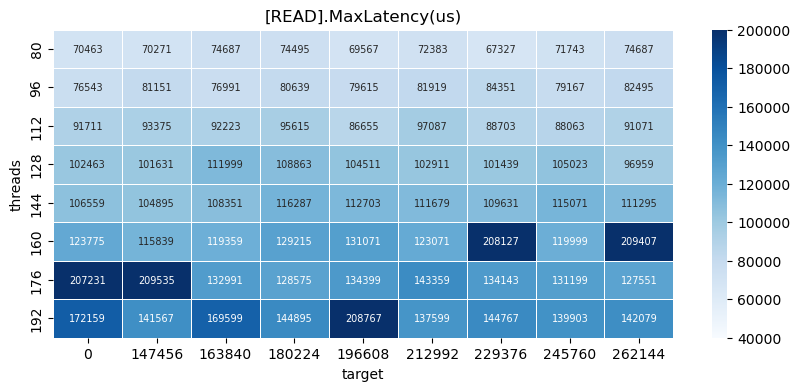

In [17]:
metric = '[READ].MaxLatency(us)'
pod_count = 1
experiment_run = 2
vmin_value = 40000
vmax_value = 200000
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

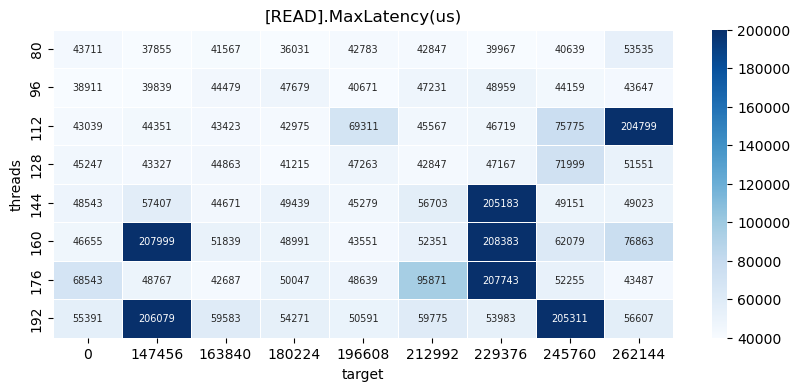

In [18]:
metric = '[READ].MaxLatency(us)'
pod_count = 8
experiment_run = 2
vmin_value = 40000
vmax_value = 200000
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

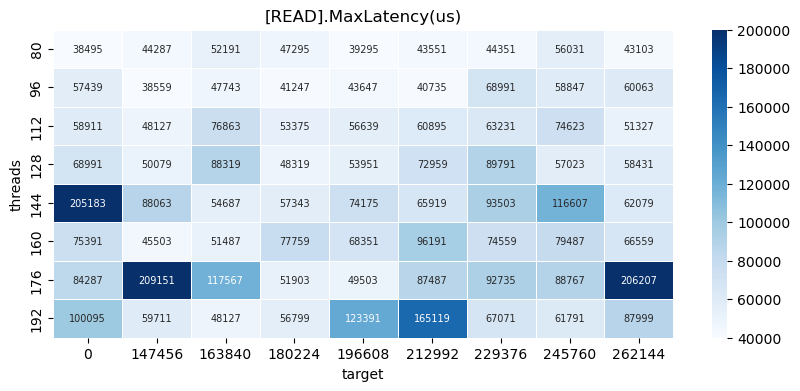

In [19]:
metric = '[READ].MaxLatency(us)'
pod_count = 16
experiment_run = 2
vmin_value = 40000
vmax_value = 200000
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

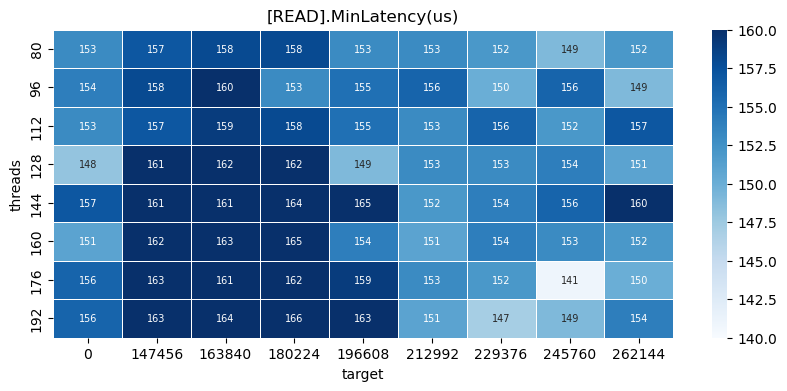

In [20]:
metric = '[READ].MinLatency(us)'
pod_count = 1
experiment_run = 2
vmin_value = 140
vmax_value = 160
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

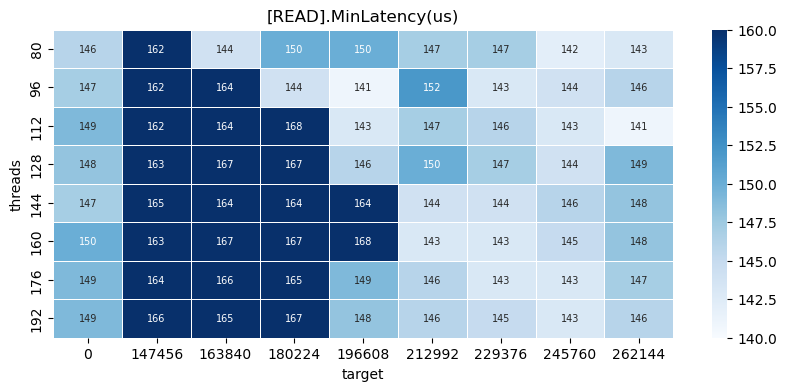

In [21]:
metric = '[READ].MinLatency(us)'
pod_count = 8
experiment_run = 2
vmin_value = 140
vmax_value = 160
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

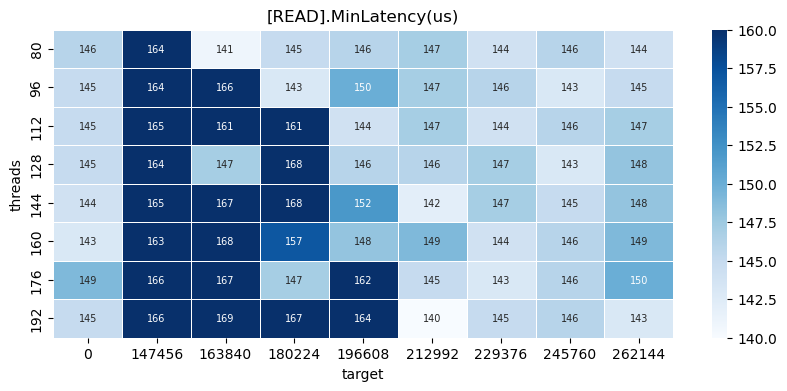

In [22]:
metric = '[READ].MinLatency(us)'
pod_count = 16
experiment_run = 2
vmin_value = 140
vmax_value = 160
plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=vmin_value, vmax_value=vmax_value)

## Line Plots of Micro Data

# Metric current_ops_per_sec

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

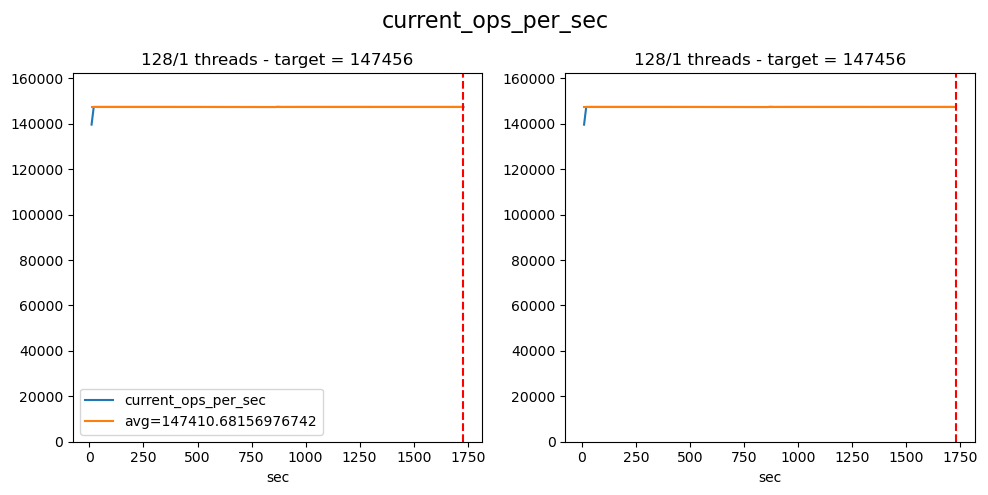

# Metric current_ops_per_sec

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

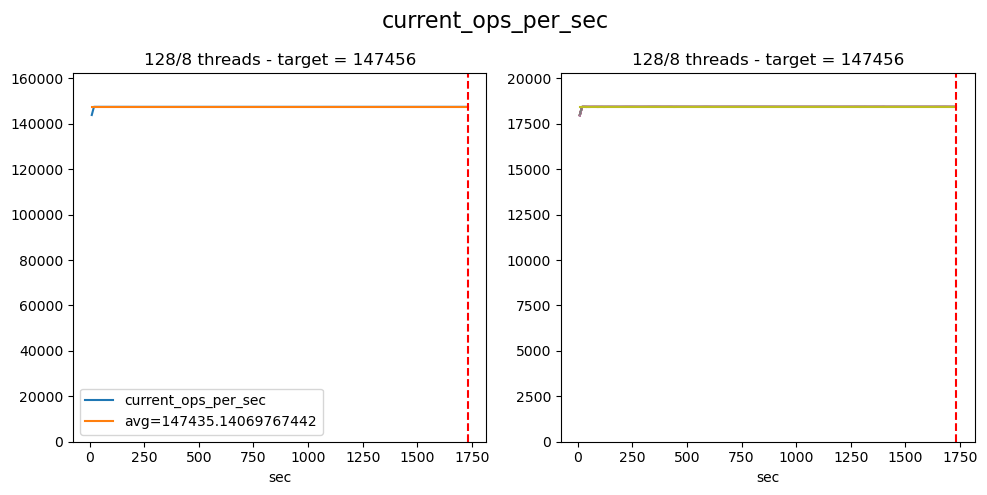

# Metric current_ops_per_sec

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

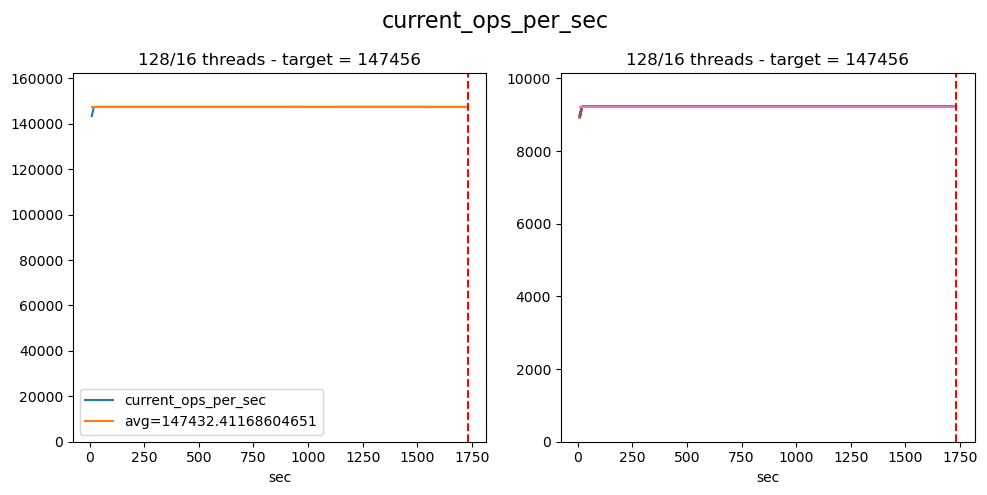

In [23]:
metric = 'current_ops_per_sec'
experiment_run = 2
target = 147456
threads = 128

pod_count = 1
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 8
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 16
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)

In [24]:
#metric = 'current_ops_per_sec'
#plot_measures(metric, smoothing=0, preset_client=10)
#plot_measures(metric, smoothing=0, preset_client=11)
#plot_measures(metric, smoothing=0, preset_client=12)


# Metric READ_Avg

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

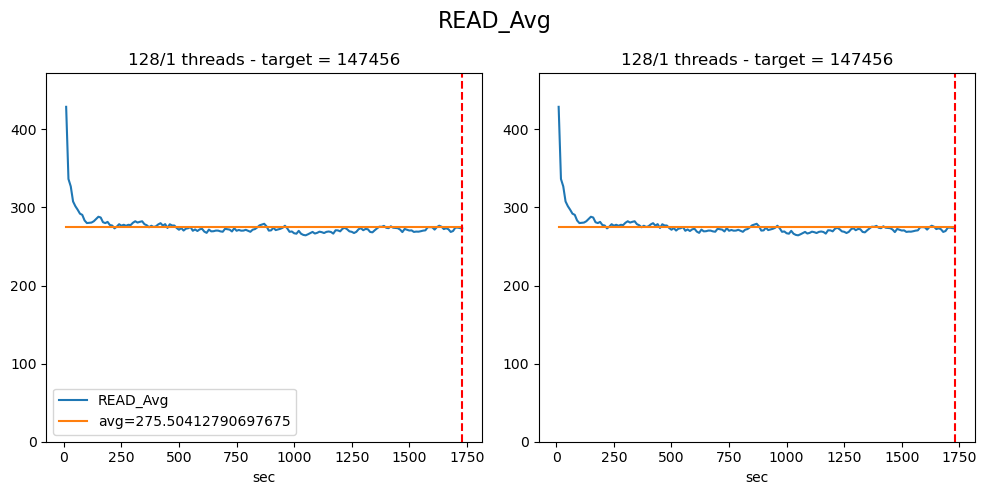

# Metric READ_Avg

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

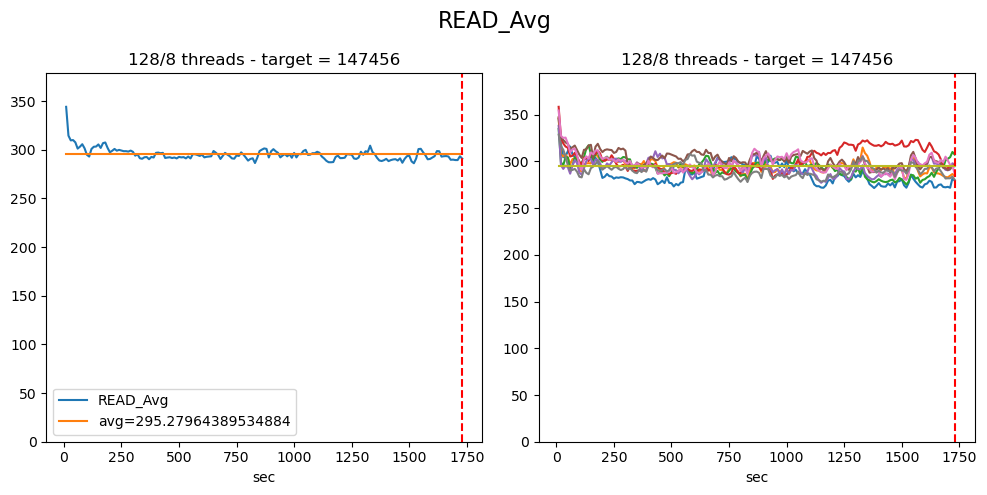

# Metric READ_Avg

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

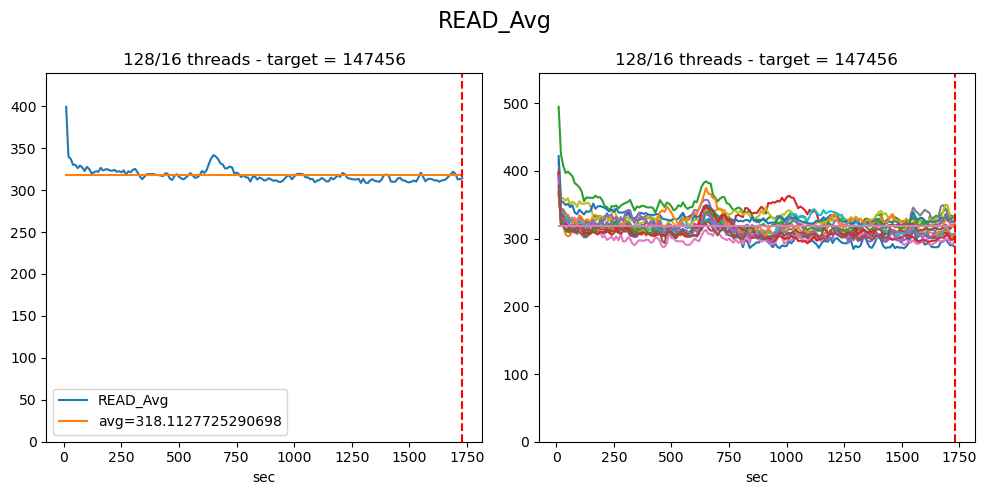

In [25]:
metric = 'READ_Avg'
experiment_run = 2
target = 147456
threads = 128

pod_count = 1
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 8
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 16
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)

# Metric READ_99

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

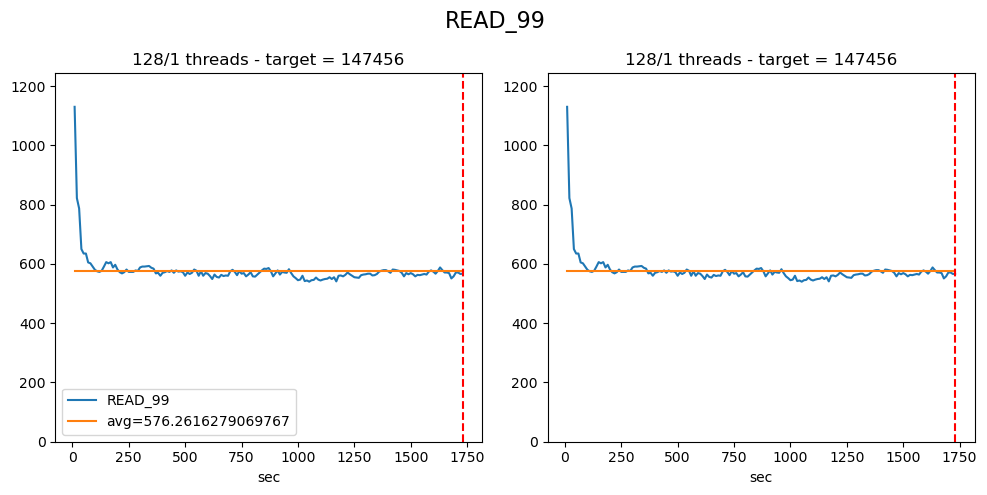

# Metric READ_99

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

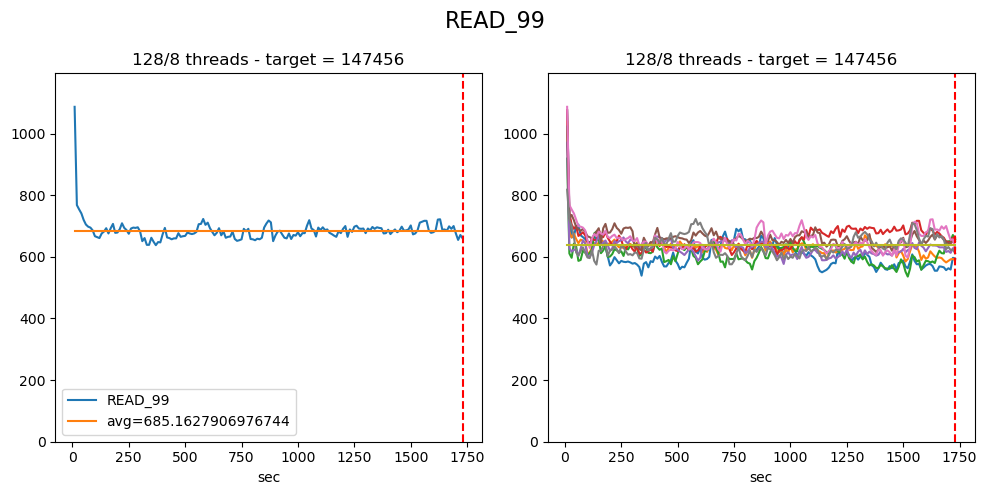

# Metric READ_99

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

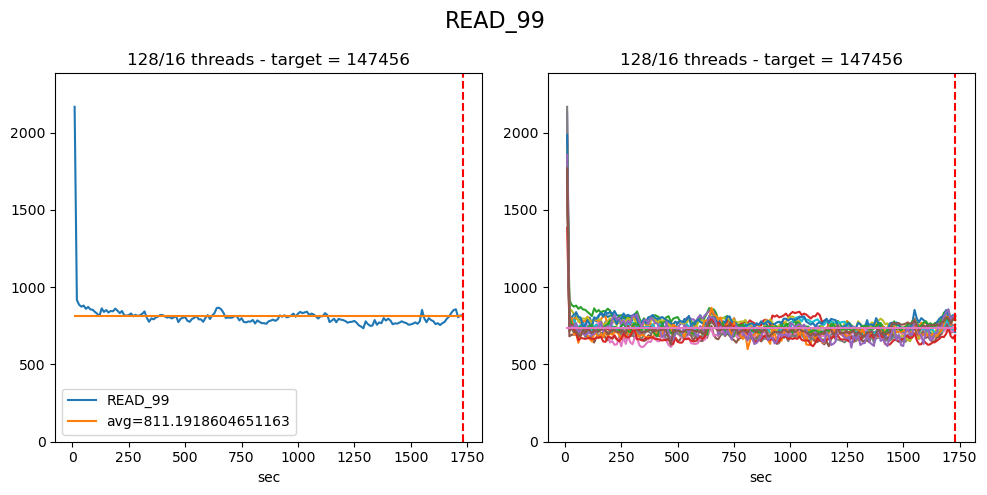

In [26]:
metric = 'READ_99'
experiment_run = 2
target = 147456
threads = 128

pod_count = 1
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 8
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 16
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)

# Metric READ_Max

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

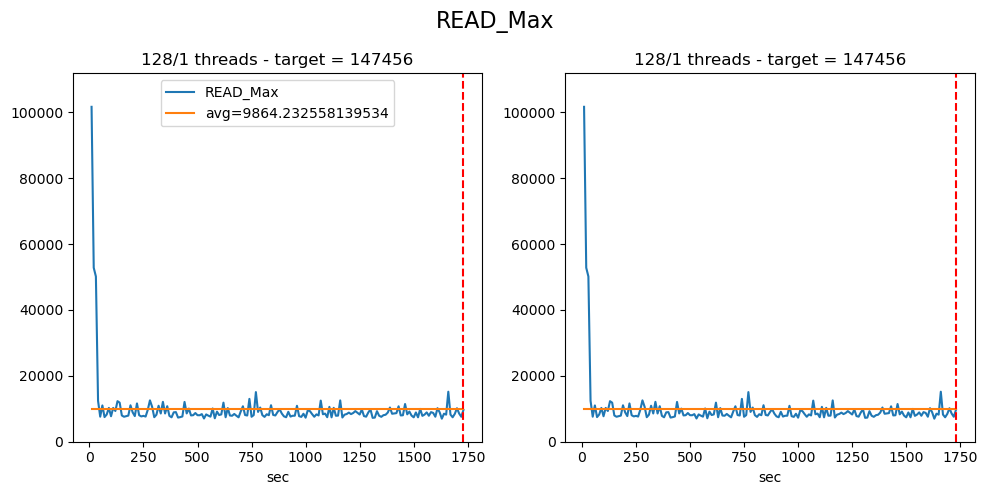

# Metric READ_Max

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

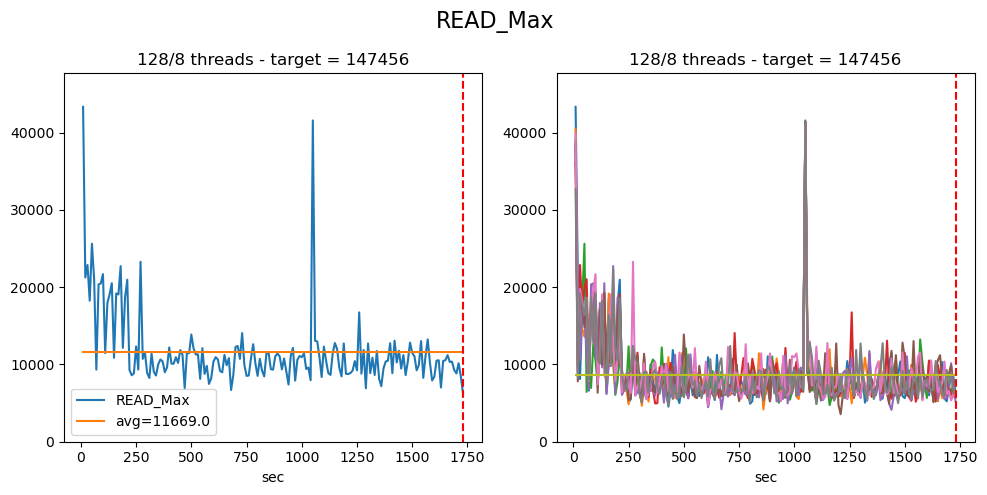

# Metric READ_Max

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

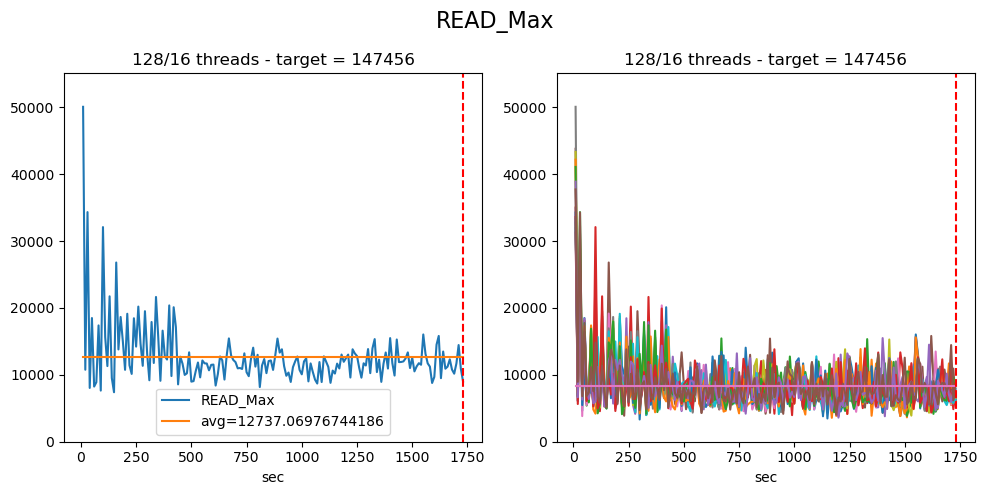

In [27]:
metric = 'READ_Max'
experiment_run = 2
target = 147456
threads = 128

pod_count = 1
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 8
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 16
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)

# Metric READ_Min

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

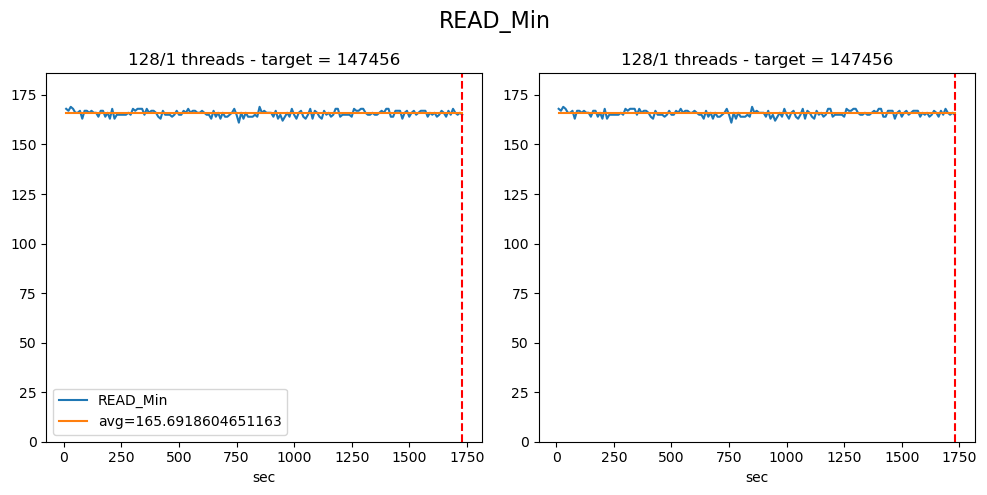

# Metric READ_Min

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

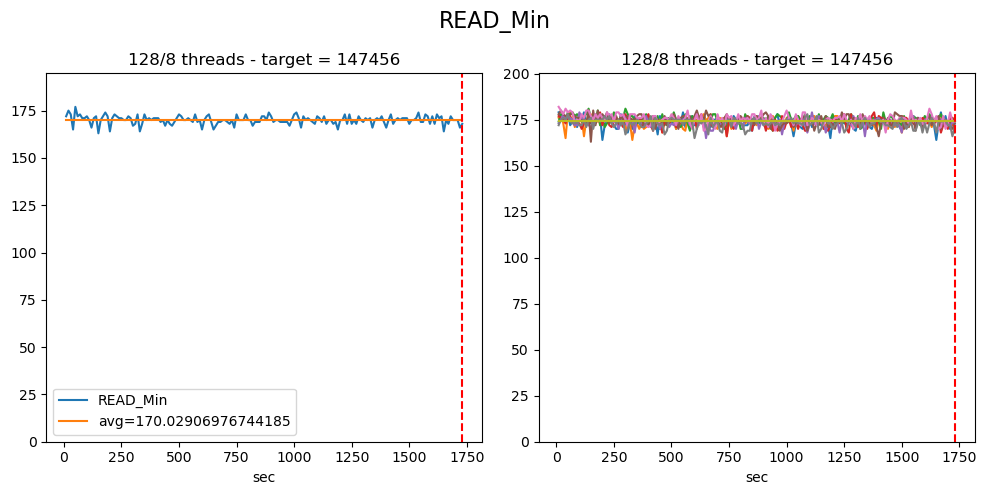

# Metric READ_Min

## Configuration PostgreSQL-64-8-196608

### Experiment run 2

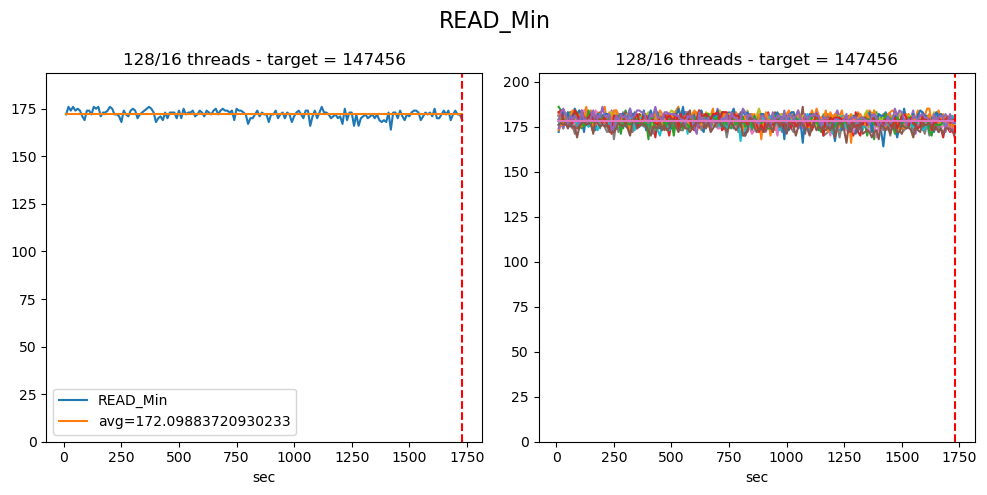

In [28]:
metric = 'READ_Min'
experiment_run = 2
target = 147456
threads = 128

pod_count = 1
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 8
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)
pod_count = 16
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, threads=threads, smoothing=0)

In [29]:
#metric = 'UPDATE_99.9'
#plot_measures(metric, smoothing=0, preset_client=3)
#plot_measures(metric, smoothing=0, preset_client=4)

## Bar Plots of Hardware Metrics

In [30]:
evaluation.transform_monitoring_results(component='stream')

evaluation.get_monitoring_metrics()

['total_cpu_memory',
 'total_cpu_memory_cached',
 'total_cpu_util',
 'total_cpu_util_max',
 'total_cpu_throttled',
 'total_cpu_util_others',
 'total_cpu_util_s',
 'total_cpu_util_user_s',
 'total_cpu_util_sys_s',
 'total_cpu_throttled_s',
 'total_cpu_util_others_s',
 'total_network_rx',
 'total_network_tx',
 'total_fs_read',
 'total_fs_write',
 'total_gpu_util',
 'total_gpu_power',
 'total_gpu_memory']

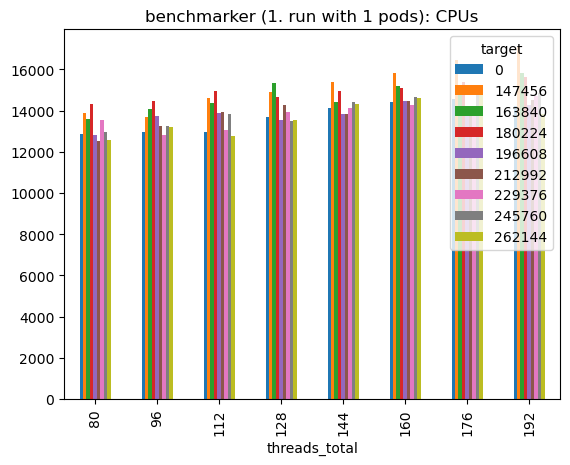

In [31]:
metric = 'CPUs'
component = 'benchmarker'
pod_count = 1
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_util_s', component=component).max() - evaluation.get_monitoring_metric('total_cpu_util_s', component=component).min()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

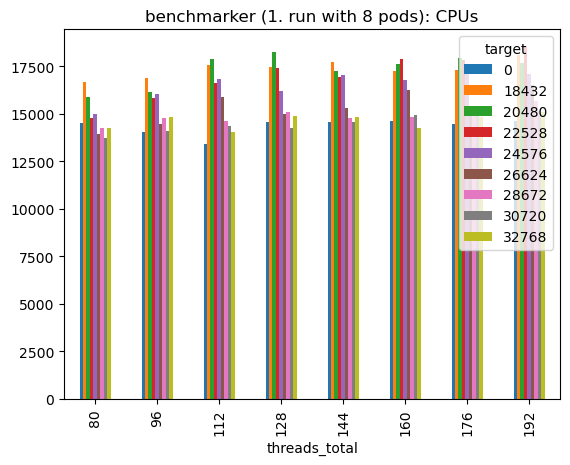

In [32]:
metric = 'CPUs'
component = 'benchmarker'
pod_count = 8
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_util_s', component=component).max() - evaluation.get_monitoring_metric('total_cpu_util_s', component=component).min()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

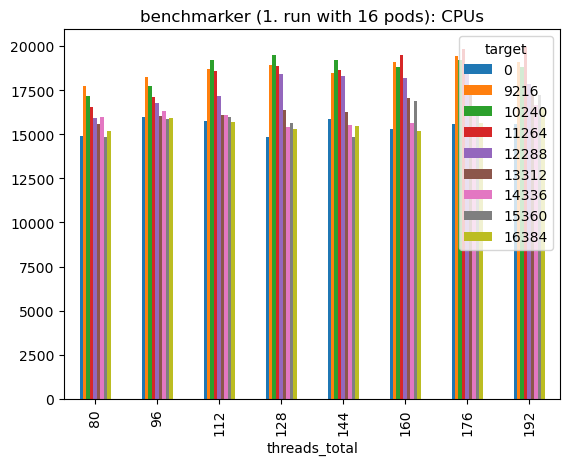

In [33]:
metric = 'CPUs'
component = 'benchmarker'
pod_count = 16
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_util_s', component=component).max() - evaluation.get_monitoring_metric('total_cpu_util_s', component=component).min()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

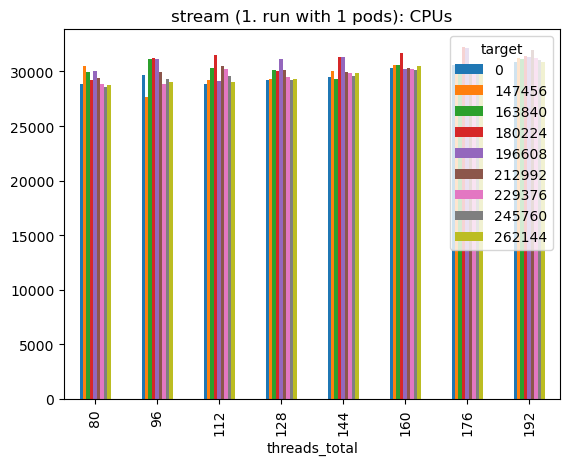

In [34]:
metric = 'CPUs'
component = 'stream'
pod_count = 1
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_util_s', component=component).max() - evaluation.get_monitoring_metric('total_cpu_util_s', component=component).min()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

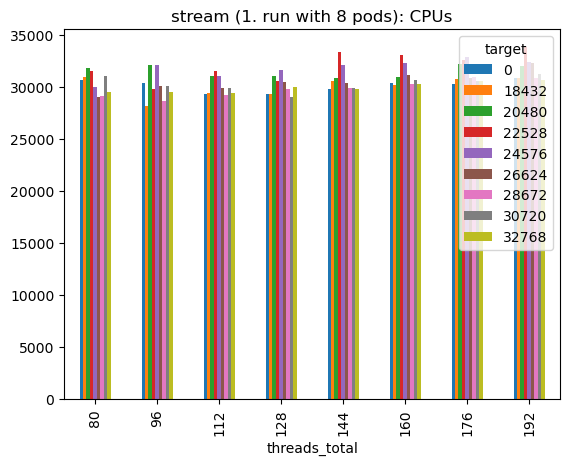

In [35]:
metric = 'CPUs'
component = 'stream'
pod_count = 8
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_util_s', component=component).max() - evaluation.get_monitoring_metric('total_cpu_util_s', component=component).min()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

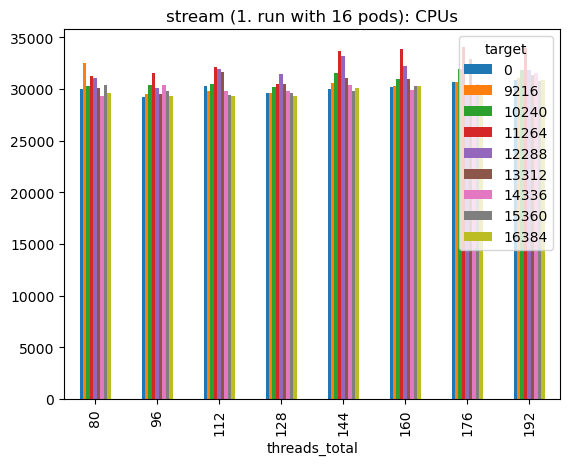

In [36]:
metric = 'CPUs'
component = 'stream'
pod_count = 16
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_util_s', component=component).max() - evaluation.get_monitoring_metric('total_cpu_util_s', component=component).min()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

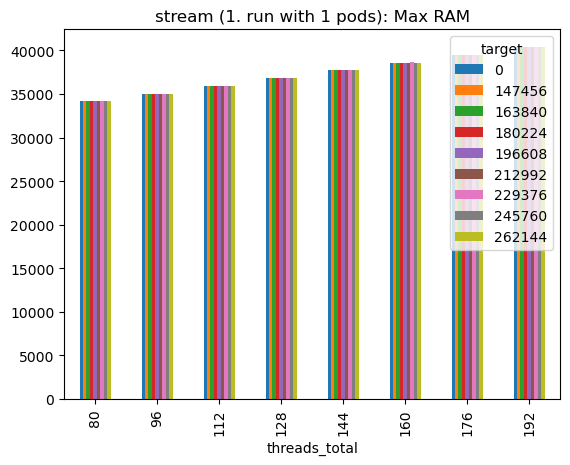

In [37]:
metric = 'Max RAM'
component = 'stream'
pod_count = 1
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_memory', component=component).max()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

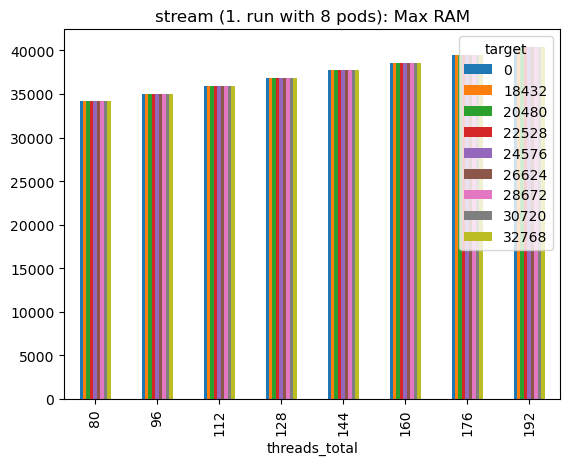

In [38]:
metric = 'Max RAM'
component = 'stream'
pod_count = 8
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_memory', component=component).max()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

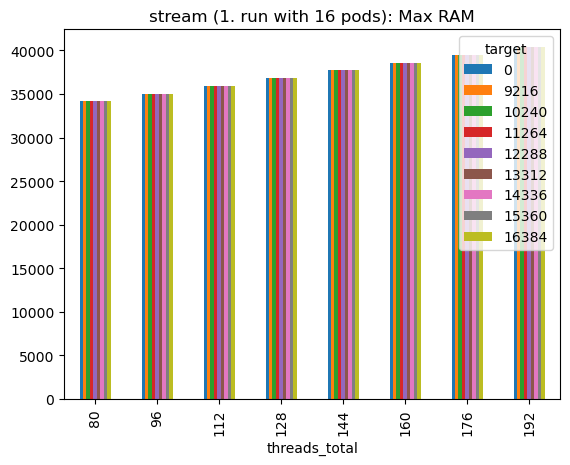

In [39]:
metric = 'Max RAM'
component = 'stream'
pod_count = 16
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_memory', component=component).max()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

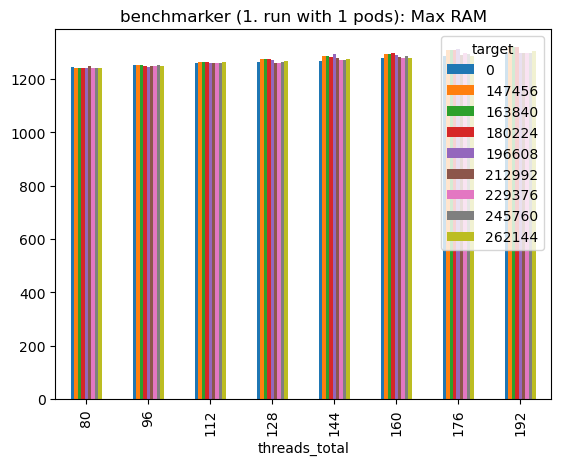

In [40]:
metric = 'Max RAM'
component = 'benchmarker'
pod_count = 1
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_memory', component=component).max()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

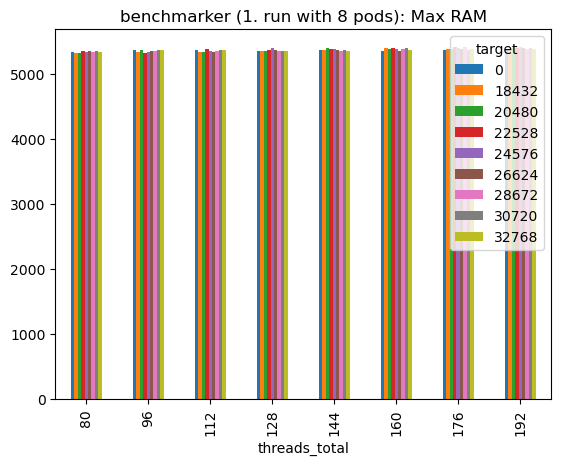

In [41]:
metric = 'Max RAM'
component = 'benchmarker'
pod_count = 8
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_memory', component=component).max()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)

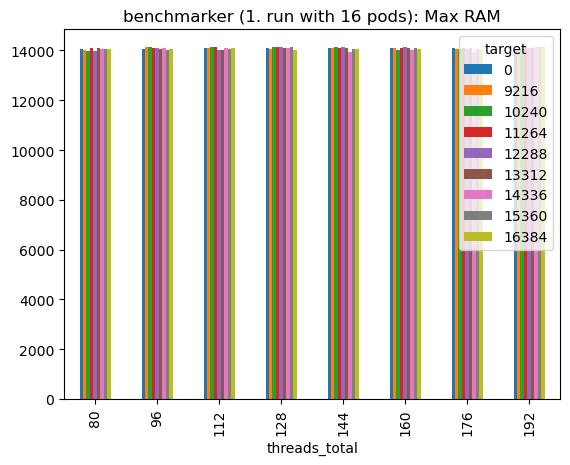

In [42]:
metric = 'Max RAM'
component = 'benchmarker'
pod_count = 16
experiment_run = 1
df = evaluation.get_monitoring_metric('total_cpu_memory', component=component).max()
plot_prometheus_metric(df, metric, component, pod_count, experiment_run)